In [1]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle


## Simon's Problem

We are given an unknown blackbox function $f$ that is either one-to-one or two-two-one. If it is two-to-one, it is guaranteed that $f(x)=f(y)\Rightarrow x\oplus y = b$ where $b$ is a hidden encoded bitstring.

## The Algorithm

1. Initialize two registers of n-qubit states:
    $$ |0\rangle^{\otimes n}|0\rangle^{\otimes n} $$
2. Apply a Hadamard gate to the first register:
    $$ \lvert \psi_2 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^{n} } \lvert x \rangle\lvert 0 \rangle^{\otimes n} $$
3. Apply the query function $U_f$:
    $$ \lvert \psi_3 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^{n} } \lvert x \rangle \lvert f(x) \rangle $$
4. Measure the second register. A value of $f(x)$ will be recorded. Since the function is two-to-one, there are two possible corresponding values for the input, $x$ or $y$. Thus the first register is now
    $$ \tfrac{1}{\sqrt{2}}\left(|x\rangle + |y\rangle\right) $$
5. Apply Hadamard to first register: 
    $$ (-1)^{x \cdot z} = (-1)^{y \cdot z} $$
meaning,
    $$ x \cdot z = y \cdot z \\
     x \cdot z = \left( x \oplus b \right) \cdot z \\
     x \cdot z = x \cdot z \oplus b \cdot z \\
     b \cdot z = 0 \text{ (mod 2)} $$
     
     
so that each time we run the algorithm, we get a unique string $z$ s.t. $b\cdot z = 0$, and we can solve for $b$ with algebraic methods such as gaussian elimination.

## Qiskit Implementation

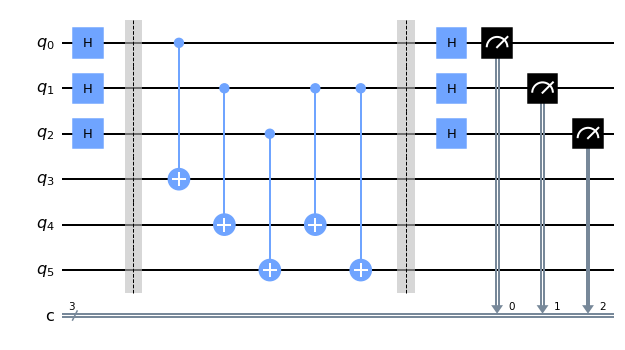

In [2]:
b = '110'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit.h(range(n))    
    
# Apply barrier for visual separation
simon_circuit.barrier()

simon_circuit += simon_oracle(b)

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to the input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw(output='mpl')


### Experiment with Simulators

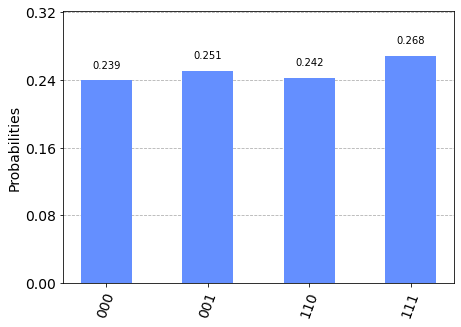

In [3]:
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(simon_circuit, shots=shots)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)


In [4]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )


110.000 = 0 (mod 2)
110.001 = 0 (mod 2)
110.110 = 0 (mod 2)
110.111 = 0 (mod 2)


### Use Real Devices

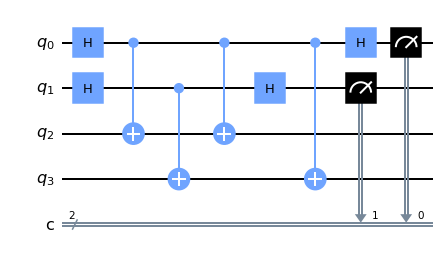

In [5]:
b = '11'
n = len(b)
simon_circuit_2 = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit_2.h(range(n))

# Query oracle
simon_circuit_2 += simon_oracle(b)

# Apply Hadamard gates to the input register
simon_circuit_2.h(range(n))

# Measure qubits
simon_circuit_2.measure(range(n), range(n))
simon_circuit_2.draw(output='mpl')


In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

In [7]:
# Execute and monitor the job
from qiskit.tools.monitor import job_monitor
shots = 1024
transpiled_simon_circuit = transpile(simon_circuit_2, backend, optimization_level=3)
qobj = assemble(transpiled_simon_circuit, shots=shots)
job = backend.run(qobj)
job_monitor(job, interval=2)


ibmqfactory.load_account:WARNING:2021-03-28 21:41:24,082: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_belem
Job Status: job has successfully run


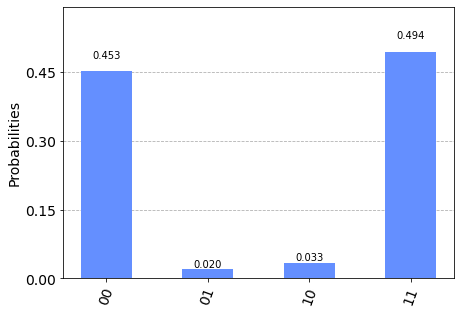

In [9]:
# Get results and plot counts
device_counts = job.result().get_counts()
plot_histogram(device_counts)


In [12]:
# Calculate the dot product of the results
print('b = ' + b)
for z in device_counts:
    if device_counts[z]/shots > 0.1:
        print( '{}.{} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), device_counts[z]*100/shots))


b = 11
11.00 = 0 (mod 2) (45.3%)
11.11 = 0 (mod 2) (49.4%)


Given these two bitstrings we can solve for b=11 with algebraic methods, but here we are just checking that the quantum portion of the algorithm is working